In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import os

torch.manual_seed(111)

assert torch.cuda.is_available(), "Ten mały manewr kosztował by nas 10 lat"
device = "cuda"

checkpoint_dir = "checkpoints/"

In [2]:
def show(x):
    x = (x + 1) / 2
    plt.imshow(x.permute(1, 2, 0).cpu().detach().numpy())

In [28]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        return self.model(x)


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(64, 1024),
            nn.Unflatten(-1, (64, 4, 4)),
            # ----
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # ---
            # nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
            # nn.LeakyReLU(0.2),
            # nn.ConvTranspose2d(64, 128, 4, stride=2, padding=1),
            # nn.LeakyReLU(0.2),
            # nn.ConvTranspose2d(128, 256, 4, stride=2, padding=1),
            # nn.LeakyReLU(0.2),
            # ---
            nn.Conv2d(256, 3, 5, stride=1, padding=2),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.model(x)

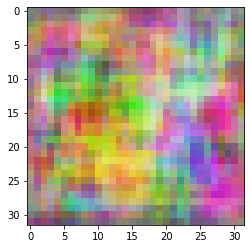

In [29]:
model = Generator()
x = torch.randn(2, 64)
x = model(x)
show(x[0])

In [5]:
class CakeDataset(Dataset):
    def __init__(self, data_dir: str):
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
        self.images = []

        for file in os.listdir(data_dir):
            img = Image.open(data_dir + file)
            img = img.resize((32, 32))
            img = transform(img)  # [0, 1]
            img = 2 * img - 1  # [-1, 1]
            self.images.append(img)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index) -> Image:
        return self.images[index]

In [8]:
dataset = CakeDataset("crawled_cakes/cake/")

In [48]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

start_epoch = 80
end_epoch = 400

loss_function = nn.MSELoss().to(device=device)
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

lr = 0.0001
betas = (0.5, 0.999)
optimizer_discriminator = torch.optim.Adam(
    discriminator.parameters(), lr=lr, betas=betas
)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)

if start_epoch > 0:
    checkpoint = torch.load(checkpoint_dir + f"model_{start_epoch-1}.pt")

    discriminator.load_state_dict(checkpoint["discriminator_weights"])
    generator.load_state_dict(checkpoint["generator_weights"])
    optimizer_discriminator.load_state_dict(checkpoint["discriminator_oprimizer"])
    optimizer_generator.load_state_dict(checkpoint["generator_optimizer"])

for epoch in range(start_epoch, end_epoch):
    for n, real_samples in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)

        input_noice = torch.randn((batch_size, 64)).to(device=device)
        generated_samples = generator(input_noice)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        
        # Training the generator
        generator.zero_grad()
        output_discriminator_generated = discriminator(generated_samples)

        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator_real = discriminator(real_samples)
        output_discriminator_generated = discriminator(generated_samples.detach())

        loss_discriminator = 0.5 * (
            loss_function(output_discriminator_real, real_samples_labels)
            + loss_function(output_discriminator_generated, generated_samples_labels)
        )
        if loss_discriminator > 0.2:
            loss_discriminator.backward()
            optimizer_discriminator.step()

        

        # Show loss
        if n == len(train_loader) - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator:.4f}", end =", ")
            print(f"Loss G.: {loss_generator:.4f}")

        if (epoch + 1) % 20 == 0:
            path = checkpoint_dir + f"model_{epoch}.pt"
            torch.save(
                {
                    "generator_weights": generator.state_dict(),
                    "generator_optimizer": optimizer_generator.state_dict(),
                    "discriminator_weights": discriminator.state_dict(),
                    "discriminator_oprimizer": optimizer_discriminator.state_dict(),
                    "epoch": epoch,
                },
                path,
            )

Epoch: 80 Loss D.: 0.2687, Loss G.: 0.2821
Epoch: 81 Loss D.: 0.2408, Loss G.: 0.3360
Epoch: 82 Loss D.: 0.2762, Loss G.: 0.2739
Epoch: 83 Loss D.: 0.2277, Loss G.: 0.2960
Epoch: 84 Loss D.: 0.2672, Loss G.: 0.2640
Epoch: 85 Loss D.: 0.2294, Loss G.: 0.2917
Epoch: 86 Loss D.: 0.2551, Loss G.: 0.2657
Epoch: 87 Loss D.: 0.2373, Loss G.: 0.3004
Epoch: 88 Loss D.: 0.2548, Loss G.: 0.3033
Epoch: 89 Loss D.: 0.2606, Loss G.: 0.2957
Epoch: 90 Loss D.: 0.2629, Loss G.: 0.2598
Epoch: 91 Loss D.: 0.2652, Loss G.: 0.2816
Epoch: 92 Loss D.: 0.2542, Loss G.: 0.2703
Epoch: 93 Loss D.: 0.2598, Loss G.: 0.3426
Epoch: 94 Loss D.: 0.2762, Loss G.: 0.2917
Epoch: 95 Loss D.: 0.2469, Loss G.: 0.3045
Epoch: 96 Loss D.: 0.2547, Loss G.: 0.2624
Epoch: 97 Loss D.: 0.2659, Loss G.: 0.3591
Epoch: 98 Loss D.: 0.2573, Loss G.: 0.3166
Epoch: 99 Loss D.: 0.2794, Loss G.: 0.3314
Epoch: 100 Loss D.: 0.2671, Loss G.: 0.3013
Epoch: 101 Loss D.: 0.2262, Loss G.: 0.3042
Epoch: 102 Loss D.: 0.2857, Loss G.: 0.2635
Epoch: 1

KeyboardInterrupt: 

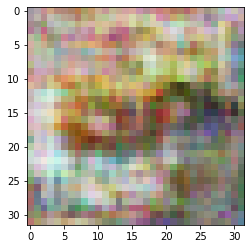

In [50]:
generator = Generator().to(device=device)
checkpoint = torch.load(checkpoint_dir + f"model_{139}.pt")
generator.load_state_dict(checkpoint["generator_weights"])
generator.eval()
x = torch.randn((10, 64)).to(device)
y = generator(x)
show(y[0])